## Libraries

In [44]:
import pandas as pd
import numpy as np
from math import log, ceil
import matplotlib.pyplot as plt
import time
from mlxtend.frequent_patterns import fpgrowth
import warnings

## Load Data Set 

In [45]:
#Load Data Set
df = pd.read_excel('Online Retail.xlsx')
print(df.head(20))

   InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5     536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6     536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7     536366     22633               HAND WARMER UNION JACK         6   
8     536366     22632            HAND WARMER RED POLKA DOT         6   
9     536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   
10    536367     22745           POPPY'S PLAYHOUSE BEDROOM          6   
11    536367     22748            POPPY'S PLAYHOUSE KITCHEN         6   
12    536367     22749    FELTCRAFT PRINCESS CHARLO

## Preproccess

In [46]:
print("The number of all records:", len(df))
# remove nan values
df = df.dropna()

# remove negative or zero values
df = df[(df['Quantity'] > 0)]

# remove negative or zero values
df = df[(df['UnitPrice'] > 0)]

# remove returned invoices
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
print("The number of records after preprocessing:", len(df))

The number of all records: 541909
The number of records after preprocessing: 397884


## Optional Check

In [47]:
# total price of products
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# top and bottom products
product_sort = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False)

print("Top 10 Products:")
print(product_sort.head(10))

print("\nBottom 10 products:")
print(product_sort.tail(10))

# top customer based on amount of buying
customer_sort = df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False)

print("\nTop 10 customers:")
print(customer_sort.head(10))

# top contries
country_sort = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)

print("\nTop 10 countries by total sales:")
print(country_sort.head(10))

# the most expensive products
product_price = df.groupby('Description')['UnitPrice'].mean()
most_expensive = product_price.sort_values(ascending=False).head(10)
print("Top 10 most expensive products:")
print(most_expensive)

Top 10 Products:
Description
PAPER CRAFT , LITTLE BIRDIE           168469.60
REGENCY CAKESTAND 3 TIER              142592.95
WHITE HANGING HEART T-LIGHT HOLDER    100448.15
JUMBO BAG RED RETROSPOT                85220.78
MEDIUM CERAMIC TOP STORAGE JAR         81416.73
POSTAGE                                77803.96
PARTY BUNTING                          68844.33
ASSORTED COLOUR BIRD ORNAMENT          56580.34
Manual                                 53779.93
RABBIT NIGHT LIGHT                     51346.20
Name: TotalPrice, dtype: float64

Bottom 10 products:
Description
RUBY GLASS CLUSTER EARRINGS            1.250
60 GOLD AND SILVER FAIRY CAKE CASES    1.100
CAT WITH SUNGLASSES BLANK CARD         0.950
HAPPY BIRTHDAY CARD TEDDY/CAKE         0.950
PINK CRYSTAL GUITAR PHONE CHARM        0.850
PURPLE FRANGIPANI HAIRCLIP             0.850
VINTAGE BLUE TINSEL REEL               0.840
SET 12 COLOURING PENCILS DOILEY        0.650
HEN HOUSE W CHICK IN NEST              0.420
PADS TO MATCH ALL CU

## Binary Matrix

In [48]:
matrix_total = (df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0))

# binary elements
matrix_total_binary = (matrix_total > 0).astype(int)

print(matrix_total_binary.head())
print("Total matrix shape:", matrix_total_binary.shape)

Description   4 PURPLE FLOCK DINNER CANDLES   50'S CHRISTMAS GIFT BAG LARGE  \
InvoiceNo                                                                     
536365                                    0                               0   
536366                                    0                               0   
536367                                    0                               0   
536368                                    0                               0   
536369                                    0                               0   

Description   DOLLY GIRL BEAKER   I LOVE LONDON MINI BACKPACK  \
InvoiceNo                                                       
536365                        0                             0   
536366                        0                             0   
536367                        0                             0   
536368                        0                             0   
536369                        0                         

## Bathces

In [49]:
# change format of date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# sorting
df = df.sort_values('InvoiceDate').reset_index(drop=True)

# set batches
invoice_list = df['InvoiceNo'].unique()
batch_size = 1000
batches = [invoice_list[i:i + batch_size] for i in range(0, len(invoice_list), batch_size)]

# labeling
batch_labels = {}
for i, batch in enumerate(batches):
    for data in batch:
        batch_labels[data] = i + 1

df['Batch'] = df['InvoiceNo'].map(batch_labels)

print(df[['InvoiceNo', 'InvoiceDate', 'Batch']].head(20))
print("The number of batches:", len(batches))


   InvoiceNo         InvoiceDate  Batch
0     536365 2010-12-01 08:26:00      1
1     536365 2010-12-01 08:26:00      1
2     536365 2010-12-01 08:26:00      1
3     536365 2010-12-01 08:26:00      1
4     536365 2010-12-01 08:26:00      1
5     536365 2010-12-01 08:26:00      1
6     536365 2010-12-01 08:26:00      1
7     536366 2010-12-01 08:28:00      1
8     536366 2010-12-01 08:28:00      1
9     536368 2010-12-01 08:34:00      1
10    536368 2010-12-01 08:34:00      1
11    536368 2010-12-01 08:34:00      1
12    536367 2010-12-01 08:34:00      1
13    536367 2010-12-01 08:34:00      1
14    536367 2010-12-01 08:34:00      1
15    536367 2010-12-01 08:34:00      1
16    536368 2010-12-01 08:34:00      1
17    536367 2010-12-01 08:34:00      1
18    536367 2010-12-01 08:34:00      1
19    536367 2010-12-01 08:34:00      1
The number of batches: 19


## Gaussian Random Projection

Domension based on Johnson Lindenstrauss Lemma: 2343
Batch 1: invoices=1000, projected dim=50
Batch 2: invoices=1000, projected dim=50
Batch 3: invoices=1000, projected dim=50
Batch 4: invoices=1000, projected dim=50
Batch 5: invoices=1000, projected dim=50
Batch 6: invoices=1000, projected dim=50
Batch 7: invoices=1000, projected dim=50
Batch 8: invoices=1000, projected dim=50
Batch 9: invoices=1000, projected dim=50
Batch 10: invoices=1000, projected dim=50
Batch 11: invoices=1000, projected dim=50
Batch 12: invoices=1000, projected dim=50
Batch 13: invoices=1000, projected dim=50
Batch 14: invoices=1000, projected dim=50
Batch 15: invoices=1000, projected dim=50
Batch 16: invoices=1000, projected dim=50
Batch 17: invoices=1000, projected dim=50
Batch 18: invoices=1000, projected dim=50
Batch 19: invoices=532, projected dim=50
Final projected data shape of GRP: (18532, 51)
Batch 1: Frobenius=6407.71, RelError=0.994, ExplainedVar=0.978
Batch 2: Frobenius=74578.78, RelError=0.994, Expl

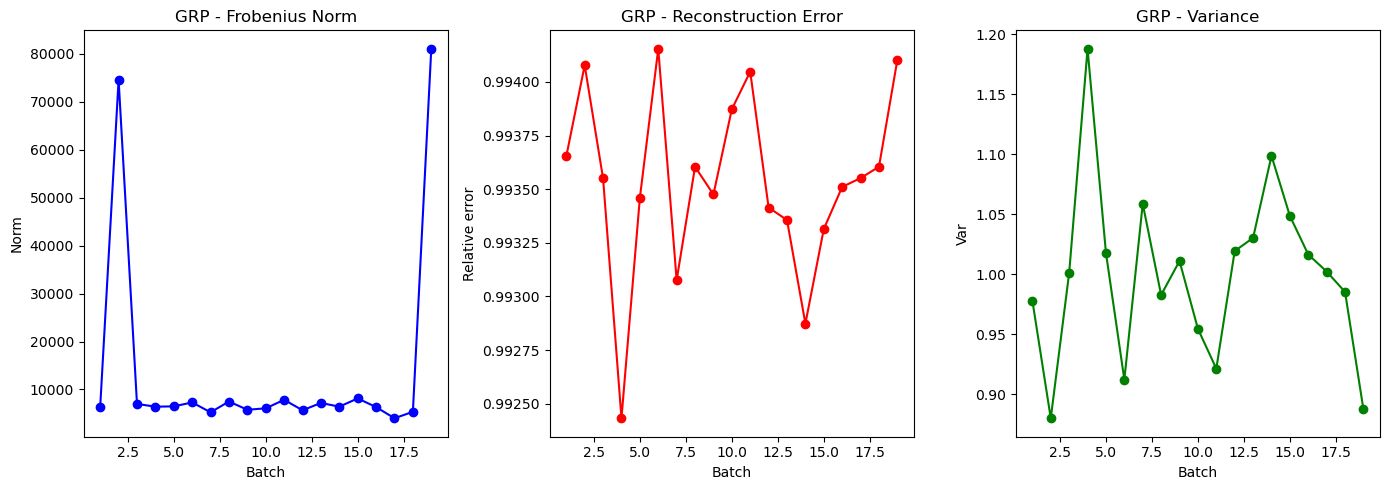

In [50]:
# johnson_lindenstrauss
def johnson_lindenstrauss(n_samples, eps=0.1):
    return int(ceil(4 * log(n_samples) / (eps**2/2 - eps**3/3)))


# gaussian_random_projection
def gaussian_random_projection(X, n_components, random_state=None):
    rng = np.random.default_rng(random_state)

    n_samples, n_features = X.shape
    k = n_components

    # Random matrix
    Random = rng.normal(loc=0.0, scale=1.0, size=(n_features, k)) / np.sqrt(k)

    X_proj = X.dot(Random)

    return X_proj

# value of components
max_invoices = df['Batch'].value_counts().max()
min_k = johnson_lindenstrauss(max_invoices, eps=0.2) 
print("Domension based on Johnson Lindenstrauss Lemma:", min_k)

n_components = min(50, min_k)

projected_batches = {}
all_projected = []

for b in sorted(df['Batch'].unique()):
    invoices = df.loc[df['Batch'] == b, 'InvoiceNo'].unique()

    X_batch = matrix_total.loc[invoices]

    X_proj = gaussian_random_projection(X_batch, n_components=n_components, random_state=b)

    proj_df = pd.DataFrame(X_proj,
                           index=invoices,
                           columns=[f'GRP_{i+1}' for i in range(n_components)])
    proj_df['Batch'] = b

    projected_batches[b] = proj_df
    all_projected.append(proj_df)

    print(f"Batch {b}: invoices={len(invoices)}, projected dim={n_components}")

all_projected_df = pd.concat(all_projected)
print("Final projected data shape of GRP:", all_projected_df.shape)

frobenius_norms = []
reconstruction_errors = []
explained_variances = []
batch_ids = []

for b in sorted(df['Batch'].unique()):
    invoices = df.loc[df['Batch'] == b, 'InvoiceNo'].unique()

    X_batch = matrix_total.loc[invoices].values

    n_samples, n_features = X_batch.shape

    rng = np.random.default_rng(b)
    Random = rng.normal(loc=0.0, scale=1.0, size=(n_features, n_components)) / np.sqrt(n_components)

    X_proj = X_batch.dot(Random)

    # Center before projection
    X_centered = X_batch - X_batch.mean(axis=0)

    # Projection
    X_proj = X_centered.dot(Random)

    # Reconstruction
    X_reconstructed = X_proj.dot(np.linalg.pinv(Random))

    # Errors
    fro_norm = np.linalg.norm(X_centered, 'fro')
    rel_error = np.linalg.norm(X_centered - X_reconstructed, 'fro') / fro_norm

    # Explained variance
    total_var = np.var(X_centered, axis=0).sum()
    proj_var = np.var(X_proj, axis=0).sum()
    explained_ratio = proj_var / total_var


    batch_ids.append(b)
    frobenius_norms.append(fro_norm)
    reconstruction_errors.append(rel_error)
    explained_variances.append(explained_ratio)

    print(f"Batch {b}: Frobenius={fro_norm:.2f}, RelError={rel_error:.3f}, ExplainedVar={explained_ratio:.3f}")

plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.plot(batch_ids, frobenius_norms, marker='o', color='blue')
plt.title('GRP - Frobenius Norm')
plt.xlabel('Batch')
plt.ylabel('Norm')

plt.subplot(1,3,2)
plt.plot(batch_ids, reconstruction_errors, marker='o', color='red')
plt.title('GRP - Reconstruction Error')
plt.xlabel('Batch')
plt.ylabel('Relative error')

plt.subplot(1,3,3)
plt.plot(batch_ids, explained_variances, marker='o', color='green')
plt.title('GRP - Variance')
plt.xlabel('Batch')
plt.ylabel('Var')

plt.tight_layout()
plt.savefig("GRP_results.pdf", format='pdf')
# plt.savefig("GRP_results_100.pdf", format='pdf')
# plt.savefig("GRP_results_500.pdf", format='pdf')
plt.show()

## Frequent Directions

Dimension based on Johnson Lindenstrauss Lemma: 2343
Batch 1: invoices=1000, projected dim=50
Batch 2: invoices=1000, projected dim=50
Batch 3: invoices=1000, projected dim=50
Batch 4: invoices=1000, projected dim=50
Batch 5: invoices=1000, projected dim=50
Batch 6: invoices=1000, projected dim=50
Batch 7: invoices=1000, projected dim=50
Batch 8: invoices=1000, projected dim=50
Batch 9: invoices=1000, projected dim=50
Batch 10: invoices=1000, projected dim=50
Batch 11: invoices=1000, projected dim=50
Batch 12: invoices=1000, projected dim=50
Batch 13: invoices=1000, projected dim=50
Batch 14: invoices=1000, projected dim=50
Batch 15: invoices=1000, projected dim=50
Batch 16: invoices=1000, projected dim=50
Batch 17: invoices=1000, projected dim=50
Batch 18: invoices=1000, projected dim=50
Batch 19: invoices=532, projected dim=50
Final projected data shape of FD: (18532, 51)
Batch 1: Frobenius=6407.71, RelError=0.285, ExplainedVar=0.919
Batch 2: Frobenius=74578.78, RelError=0.031, Expla

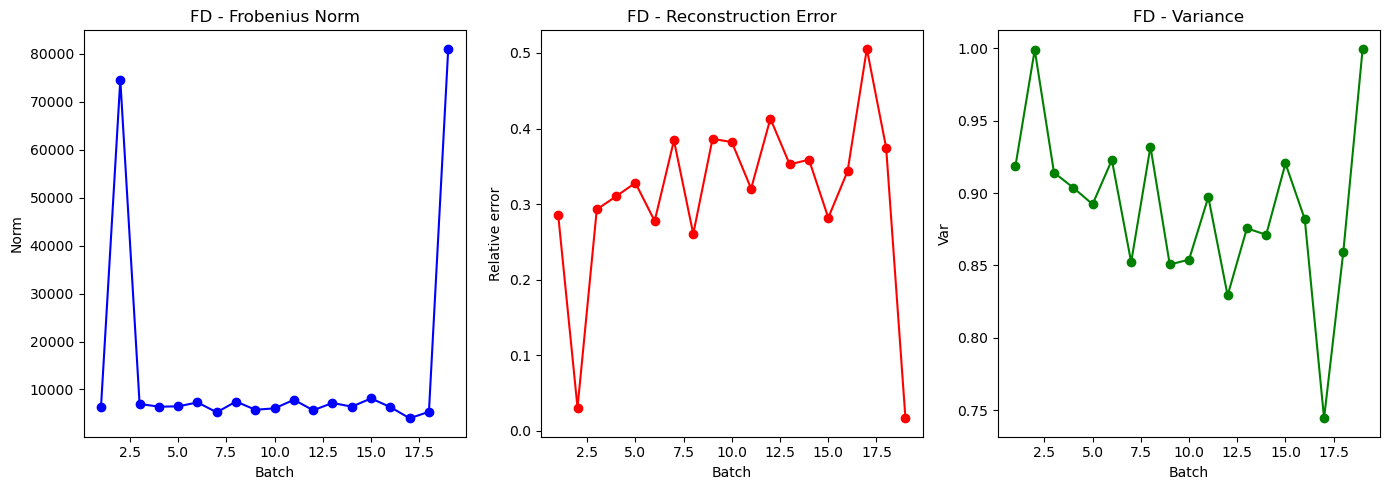

In [51]:
def frequent_directions(X, n_components):
    n_samples, n_features = X.shape
    l = n_components
    B = np.zeros((2 * l, n_features))

    for i in range(n_samples):
        x = X[i, :]
        if np.all(x == 0):
            continue
        # Add row
        idx = np.where(~B.any(axis=1))[0]
        if len(idx) > 0:
            B[idx[0], :] = x
        else:
            # SVD shrinkage
            U, s, Vt = np.linalg.svd(B, full_matrices=False)
            delta = s[l] ** 2
            s_shrunk = np.sqrt(np.maximum(s[:l] ** 2 - delta, 0))
            B = np.dot(np.diag(s_shrunk), Vt[:l, :])
            # Replace first empty row
            B = np.vstack((B, np.zeros((l, n_features))))
            B[l, :] = x
    # Final compression
    U, s, Vt = np.linalg.svd(B, full_matrices=False)
    return Vt[:l, :].T


def johnson_lindenstrauss(n_samples, eps=0.1):
    return int(ceil(4 * log(n_samples) / (eps**2 / 2 - eps**3 / 3)))


max_invoices = df['Batch'].value_counts().max()
min_k = johnson_lindenstrauss(max_invoices, eps=0.2)
print("Dimension based on Johnson Lindenstrauss Lemma:", min_k)

n_components = min(50, min_k)

projected_batches = {}
all_projected = []

for b in sorted(df['Batch'].unique()):
    invoices = df.loc[df['Batch'] == b, 'InvoiceNo'].unique()
    X_batch = matrix_total.loc[invoices].values
    n_samples, n_features = X_batch.shape

    FD_matrix = frequent_directions(X_batch, n_components)
    X_proj = X_batch.dot(FD_matrix)

    proj_df = pd.DataFrame(X_proj,
                           index=invoices,
                           columns=[f'FD_{i+1}' for i in range(n_components)])
    proj_df['Batch'] = b

    projected_batches[b] = proj_df
    all_projected.append(proj_df)

    print(f"Batch {b}: invoices={len(invoices)}, projected dim={n_components}")

all_projected_df = pd.concat(all_projected)
print("Final projected data shape of FD:", all_projected_df.shape)

frobenius_norms = []
reconstruction_errors = []
explained_variances = []
batch_ids = []

for b in sorted(df['Batch'].unique()):
    invoices = df.loc[df['Batch'] == b, 'InvoiceNo'].unique()
    X_batch = matrix_total.loc[invoices].values
    n_samples, n_features = X_batch.shape

    FD_matrix = frequent_directions(X_batch, n_components)
    X_proj = X_batch.dot(FD_matrix)

    X_centered = X_batch - X_batch.mean(axis=0)
    X_proj = X_centered.dot(FD_matrix)
    X_reconstructed = X_proj.dot(np.linalg.pinv(FD_matrix))

    fro_norm = np.linalg.norm(X_centered, 'fro')
    rel_error = np.linalg.norm(X_centered - X_reconstructed, 'fro') / fro_norm
    total_var = np.var(X_centered, axis=0).sum()
    proj_var = np.var(X_proj, axis=0).sum()
    explained_ratio = proj_var / total_var

    batch_ids.append(b)
    frobenius_norms.append(fro_norm)
    reconstruction_errors.append(rel_error)
    explained_variances.append(explained_ratio)

    print(f"Batch {b}: Frobenius={fro_norm:.2f}, RelError={rel_error:.3f}, ExplainedVar={explained_ratio:.3f}")

# Plot
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(batch_ids, frobenius_norms, marker='o', color='blue')
plt.title('FD - Frobenius Norm')
plt.xlabel('Batch')
plt.ylabel('Norm')

plt.subplot(1, 3, 2)
plt.plot(batch_ids, reconstruction_errors, marker='o', color='red')
plt.title('FD - Reconstruction Error')
plt.xlabel('Batch')
plt.ylabel('Relative error')

plt.subplot(1, 3, 3)
plt.plot(batch_ids, explained_variances, marker='o', color='green')
plt.title('FD - Variance')
plt.xlabel('Batch')
plt.ylabel('Var')

plt.tight_layout()
plt.savefig("FD_results.pdf", format='pdf')
# plt.savefig("FD_results_100.pdf", format='pdf')
# plt.savefig("FD_results_500.pdf", format='pdf')
plt.show()


## Incremental PCA

Batch 1: Frobenius=6416.28, RelError=0.844, ExplainedVar=0.287
Batch 2: Frobenius=74612.51, RelError=0.896, ExplainedVar=0.197
Batch 3: Frobenius=6991.78, RelError=0.885, ExplainedVar=0.217
Batch 4: Frobenius=6413.97, RelError=0.943, ExplainedVar=0.109
Batch 5: Frobenius=6483.54, RelError=0.901, ExplainedVar=0.189
Batch 6: Frobenius=7304.12, RelError=0.871, ExplainedVar=0.240
Batch 7: Frobenius=5243.73, RelError=0.936, ExplainedVar=0.124
Batch 8: Frobenius=7489.55, RelError=0.964, ExplainedVar=0.070
Batch 9: Frobenius=5775.54, RelError=0.944, ExplainedVar=0.108
Batch 10: Frobenius=6067.66, RelError=0.952, ExplainedVar=0.092
Batch 11: Frobenius=7854.23, RelError=0.840, ExplainedVar=0.293
Batch 12: Frobenius=5662.12, RelError=0.941, ExplainedVar=0.115
Batch 13: Frobenius=7193.75, RelError=0.958, ExplainedVar=0.081
Batch 14: Frobenius=6419.57, RelError=0.926, ExplainedVar=0.141
Batch 15: Frobenius=8137.81, RelError=0.629, ExplainedVar=0.605
Batch 16: Frobenius=6328.39, RelError=0.875, Exp

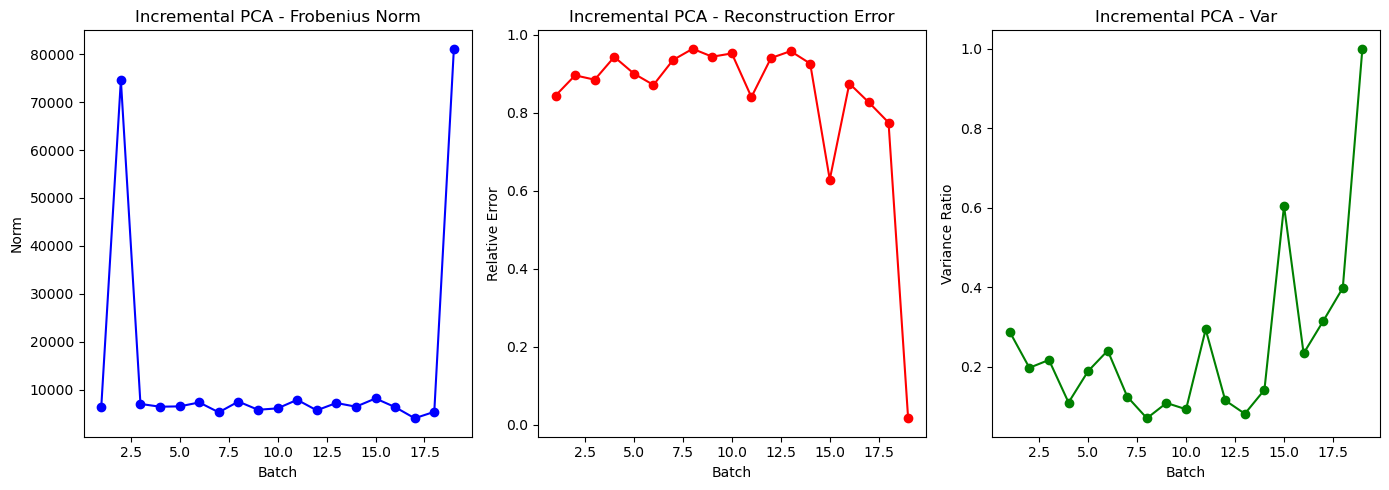

In [52]:
def incremental_pca(X_batches, n_components):
    Proj = None
    mean = None
    total_samples = 0

    for X in X_batches:
        if X.ndim == 1:
            X = X.reshape(1, -1)
        n = X.shape[0]

        if mean is None:
            mean = X.mean(axis=0)
        else:
            mean = (mean * total_samples + X.mean(axis=0) * n) / (total_samples + n)
        total_samples += n

        X_centered = X - mean

        if Proj is not None:
            X_old_approx = X_centered @ Proj @ Proj.T
            X_new = np.vstack([X_old_approx, X_centered])
        else:
            X_new = X_centered

        if X_new.size == 0:
            continue

        U, S, Vt = np.linalg.svd(X_new, full_matrices=False)
        Proj = Vt[:n_components, :].T

    return Proj, mean

l = 50 
X_batches = []

batch_ids = sorted(df['Batch'].unique())
for b in batch_ids:
    invoices = df.loc[df['Batch'] == b, 'InvoiceNo'].unique()
    invoices = [i for i in invoices if i in matrix_total.index]
    if not invoices:
        continue
    X_batches.append(matrix_total.loc[invoices].values)

Proj, mean = incremental_pca(X_batches, n_components=l)

fro_errors = []
var_ratios = []
rec_errors = []

for idx, X in enumerate(X_batches):
    X_centered = X - mean
    X_proj = X_centered @ Proj
    X_rec = X_proj @ Proj.T

    fro_norm = np.linalg.norm(X_centered, 'fro')
    rel_error = np.linalg.norm(X_centered - X_rec, 'fro') / fro_norm
    total_var = np.var(X_centered, axis=0).sum()
    proj_var = np.var(X_proj, axis=0).sum()
    explained_ratio = proj_var / total_var

    fro_errors.append(fro_norm)
    rec_errors.append(rel_error)
    var_ratios.append(explained_ratio)

    print(f"Batch {batch_ids[idx]}: Frobenius={fro_norm:.2f}, "
          f"RelError={rel_error:.3f}, ExplainedVar={explained_ratio:.3f}")

plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.plot(batch_ids[:len(fro_errors)], fro_errors, marker='o', color='blue')
plt.title('Incremental PCA - Frobenius Norm')
plt.xlabel('Batch')
plt.ylabel('Norm')

plt.subplot(1,3,2)
plt.plot(batch_ids[:len(fro_errors)], rec_errors, marker='o', color='red')
plt.title('Incremental PCA - Reconstruction Error')
plt.xlabel('Batch')
plt.ylabel('Relative Error')

plt.subplot(1,3,3)
plt.plot(batch_ids[:len(fro_errors)], var_ratios, marker='o', color='green')
plt.title('Incremental PCA - Var')
plt.xlabel('Batch')
plt.ylabel('Variance Ratio')

plt.tight_layout()
plt.savefig("IPCA_results.pdf", format='pdf')
# plt.savefig("IPCA_results_100.pdf", format='pdf')
# plt.savefig("IPCA_results_500.pdf", format='pdf')
plt.show()


## FP-Growth

In [53]:
def run_fp_growth(df, min_support, name="dataset"):
    start = time.time()
    res = fpgrowth(df, min_support=min_support, use_colnames=True)
    end = time.time()
    print(f"{name}: {len(res)} patterns found in {end - start:.2f}s\n")
    return res, end - start

# Sampling 
n_rows = matrix_total.shape[0]
sample_idx = np.random.choice(n_rows, 1000, replace=False)
X = matrix_total.iloc[sample_idx].values
MIN_SUPPORT = 0.1
n_components = 10

# Original 
df_original = pd.DataFrame((X > 0).astype(bool))
patterns_orig, time_orig = run_fp_growth(df_original, MIN_SUPPORT, name="Original")

# GRP 
X_grp = gaussian_random_projection(X, n_components=n_components, random_state=None)
df_grp = pd.DataFrame((X_grp > 0).astype(bool))
patterns_grp, time_grp = run_fp_growth(df_grp, MIN_SUPPORT, name="GRP")

# FD 
FD_matrix = frequent_directions(X, n_components)
X_fd = X.dot(FD_matrix) 
df_fd = pd.DataFrame((X_fd > 0).astype(bool))
patterns_fd, time_fd = run_fp_growth(df_fd, MIN_SUPPORT, name="FD")

# Incremental PCA 
Proj, mean = incremental_pca([X], n_components=n_components)
X_centered = X - mean
X_ipca = X_centered.dot(Proj)
df_ipca = pd.DataFrame((X_ipca > 0).astype(bool))
patterns_ipca, time_ipca = run_fp_growth(df_ipca, MIN_SUPPORT, name="Incremental PCA")


Original: 1 patterns found in 0.17s

GRP: 149 patterns found in 0.77s

FD: 48 patterns found in 0.23s

Incremental PCA: 128 patterns found in 0.63s



## Extra Data

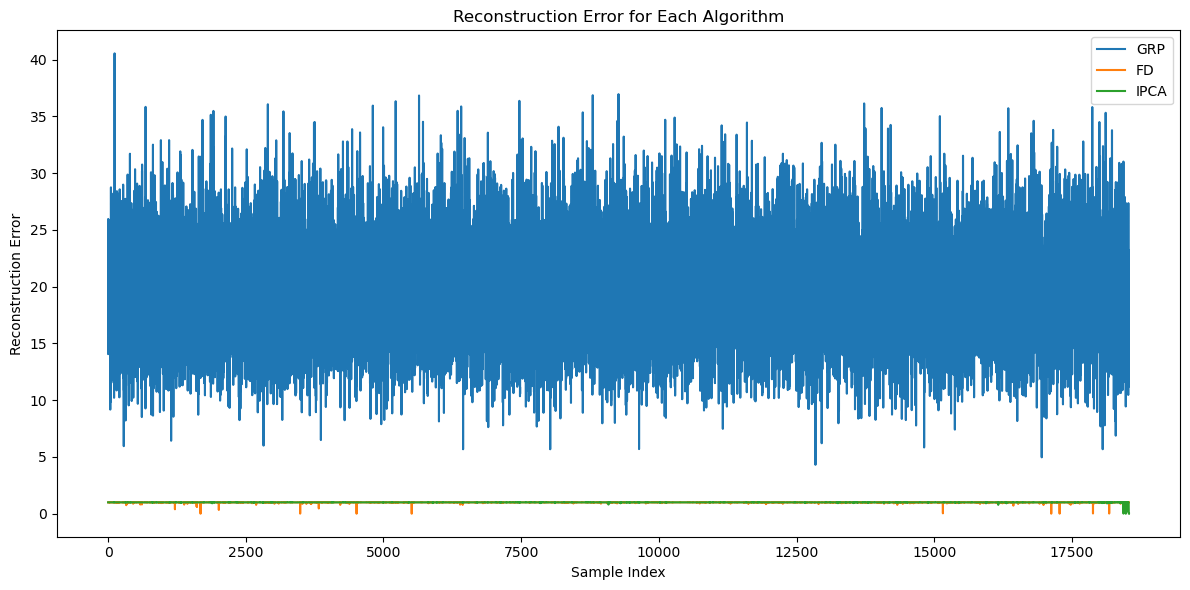

Normal Error:
GRP     19.694917
FD       0.997453
IPCA     0.998986
dtype: float64
Augmented Error:
GRP     18.716464
FD       0.999923
IPCA     0.001878
dtype: float64
GRP detected extra:
Index([581400, 581423, 581432, 581456, 581581], dtype='object')
FD detected extra:
Index([581483, 581501, 'extra_1', 'extra_2', 'extra_5'], dtype='object')
IPCA detected extra:
Index([581110, 581115, 581179, 581180, 581483], dtype='object')


In [54]:
n_extra = 5
np.random.seed(42)

extra = np.zeros((n_extra, matrix_total.shape[1]))
for i in range(n_extra):
    cols = np.random.choice(matrix_total.shape[1], size=8, replace=False)
    extra[i, cols] = np.random.randint(50, 200, size=8)

extra_df = pd.DataFrame(extra, columns=matrix_total.columns)
extra_df.index = [f"extra_{i+1}" for i in range(n_extra)]

matrix_aug = pd.concat([matrix_total, extra_df])

def reconstruction_error_grp(X, n_components, seed=42):
    rng = np.random.default_rng(seed)
    n_samples, n_features = X.shape
    R = rng.normal(0.0, 1.0, size=(n_features, n_components)) / np.sqrt(n_components)
    X_proj = X @ R
    X_rec = X_proj @ R.T
    errors = np.linalg.norm(X - X_rec, axis=1) / (np.linalg.norm(X, axis=1) + 1e-8)
    return errors

def reconstruction_error_fd(X, l):
    n, d = X.shape
    if n > 2*l:
        idx = np.random.choice(n, 2*l, replace=False)
        X_sub = X[idx, :]
    else:
        X_sub = X.copy()
    U, s, Vt = np.linalg.svd(X_sub, full_matrices=False)
    shrink_value = s[min(l, len(s)) - 1]**2
    s_shrink = np.sqrt(np.maximum(s[:l]**2 - shrink_value, 0))
    B = np.diag(s_shrink) @ Vt[:l, :]
    X_rec = X @ B.T @ np.linalg.pinv(B @ B.T) @ B
    errors = np.linalg.norm(X - X_rec, axis=1) / (np.linalg.norm(X, axis=1) + 1e-8)
    return errors

def reconstruction_error_ipca(X_batches, n_components):
    W = None
    mean = None
    total_samples = 0
    for X in X_batches:
        if X.ndim == 1:
            X = X.reshape(1, -1)
        n = X.shape[0]
        if mean is None:
            mean = X.mean(axis=0)
        else:
            mean = (mean * total_samples + X.mean(axis=0) * n) / (total_samples + n)
        total_samples += n
        X_centered = X - mean
        if W is not None:
            X_old_approx = X_centered @ W @ W.T
            X_aug = np.vstack([X_old_approx, X_centered])
        else:
            X_aug = X_centered
        if X_aug.size == 0:
            continue
        U, S, Vt = np.linalg.svd(X_aug, full_matrices=False)
        W = Vt[:n_components, :].T
    X_all = np.vstack(X_batches)
    X_centered = X_all - mean
    X_proj = X_centered @ W
    X_rec = X_proj @ W.T
    errors = np.linalg.norm(X_centered - X_rec, axis=1) / (np.linalg.norm(X_centered, axis=1) + 1e-8)
    return errors

X = matrix_aug.values
X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-9)

split_size = 200
X_batches = [X[i:i+split_size] for i in range(0, len(X), split_size)]

errors_grp = reconstruction_error_grp(X, n_components=10, seed=42)
errors_fd = reconstruction_error_fd(X, l=10)
errors_ipca = reconstruction_error_ipca(X_batches, n_components=10)

errors_df = pd.DataFrame({
    "GRP": errors_grp,
    "FD": errors_fd,
    "IPCA": errors_ipca
}, index=matrix_aug.index)

plt.figure(figsize=(12,6))
for col in errors_df.columns:
    plt.plot(errors_df[col].values, label=col)

plt.title('Reconstruction Error for Each Algorithm')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.tight_layout()
plt.savefig("Detect.pdf", format='pdf')
plt.show()

print("Normal Error:")
print(errors_df.iloc[:-n_extra].mean())

print("Augmented Error:")
print(errors_df.iloc[-n_extra:].mean())

for method in errors_df.columns:
    threshold = errors_df[method].quantile(0.95)
    detected = errors_df.index[errors_df[method] > threshold]
    print(f"{method} detected extra:")
    print(detected[-n_extra:])
